In [1]:
!pip install anaflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 19.6 MB/s 


In [2]:
import numpy as np
import sympy as sp
import anaflow
import pandas as pd
from sympy import *
from sympy.solvers.solveset import linsolve
import scipy.special as sc
from scipy import integrate
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 15; mp.pretty = True

In [3]:
#Исходные данные
q = 0.00092 # [m3/c] - дебит скважины
B = 1.25 # [m3/m3] - объемный коэффициент
k = 5*1e-15 # [m2] - изотропная проницаемость
h = 9.144 # [m] - толщина пласта
f = 0.3 # [] - пористость
c = 1.47*1e-9 # [1/Pa] - сжимаемость флюида
cf = 1 * 1e-9 # [1/Pa] - сжимаемость породы
ct = (c + cf) # [1/Pa] - общая породы
rw = 0.1524 # [m] - радиус ствола скважины
r = 0.1524 # [m] - радиальная координата и расстояние
mu = 3*1e-3 # [Pa*c] - вязкость
eta = k / (mu * f * ct) # коэф пьезопроводности 
eta_x = (eta ** 2 * 10) ** (1/2) # [] - коэффициент пьезопроводности в x направлении
eta_y = eta_x # [] - коэффициент пьезопроводности в y направлении
eta_z = 0.1 * eta_x # [] - коэффициент пьезопроводности в z направлении
x = rw # [m] - расстояние в x направлении
x_s = 0 # [m] - координата источника в x направлении
y = 0 # [m] - расстояние в y направлении
y_s = 0 # [m] - координата источника в y направлении
z = 5 # [m] - расстояние в z направлении
z_w = 5 # [m] - координата скважины в z направлении
l = rw
x_d = 0
y_d = 0
x_wd = 0
y_wd = 0
tetta = 0
Lh = 400
pi = 3.44738E+7

In [4]:
def td_2_t(td, eta = eta, l = l):
  return l ** 2 * td / eta

In [5]:
def hd(h = h, k = k, kz = 1 * k, l = l):
  return h * (k / kz) ** 0.5 / l


In [14]:
def en(u, n, hd = hd()):
  return (u + n ** 2 * np.pi ** 2 / hd ** 2) ** 0.5

In [15]:
def func_hor_well_int_1(s, a ,n, x_d = x_d, x_wd = x_wd, y_d = y_d, y_wd = y_wd, k = k, kx = k):
  return sc.kn(0, ((x_d - x_wd - a * (k / kx) ** 0.5) ** 2 + (y_d - y_wd) ** 2) ** 0.5 * en(s,(2 * n - 1))) 

In [16]:
def func_hor_well_int_11(s, n, h = h, z = z, z_w = z_w, l = l, Lh= Lh):
  v = np.zeros(len(s))
  m = 0
  an = np.linspace(-Lh/(2*l), (Lh/(2*l)), 1000)
  for i in s:
    v[m] = np.trapz(func_hor_well_int_1(i, an,n), an)
    m += 1
  return  np.sin((2 * n - 1) * np.pi * z / (2 * h)) * np.cos((2 * n - 1) * np.pi * z_w / (2 * h)) * v

In [23]:
def sum_hor_well_int(s):
  m = 1
  result_1 = 0
  while (m < 800):
    result_1 += func_hor_well_int_11(s,m)
    m += 1
  return result_1

In [24]:
def hor_well_int_part(s,  h = h, hd = hd(), q = q, k = k, B = B, mu = mu, Lh = Lh):
  return q * mu * B  / ( np.pi * k  * hd * Lh * s) * sum_hor_well_int(s) 

In [25]:
path = 'https://raw.githubusercontent.com/AvtomonovPavel/Method-of-sources/main/Examples/example_3.3.4'
df = pd.read_table(path, sep='\s+', engine = 'python')

In [26]:
t = np.logspace(-1, 3.5, 100)
pd_lps = anaflow.get_lap_inv(hor_well_int_part )
p_res = pd_lps(t)
t_res = td_2_t(t)

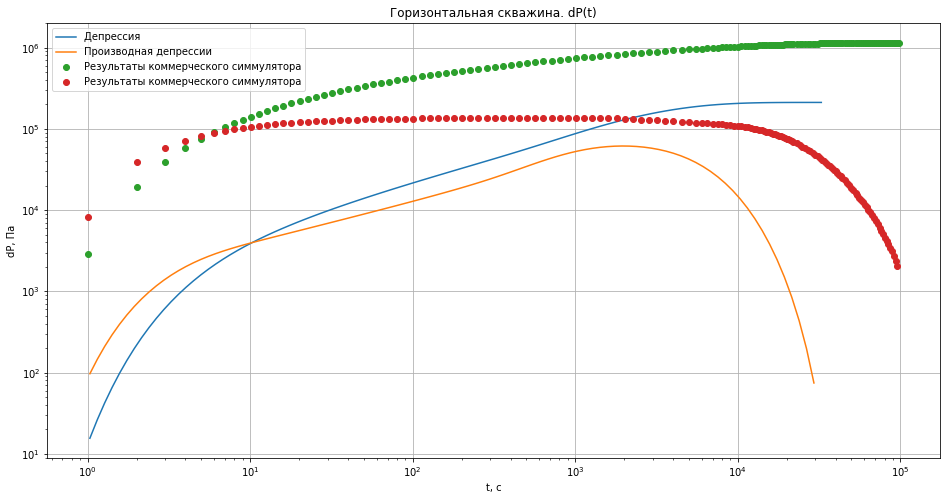

In [27]:

fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)

pd_lps = anaflow.get_lap_inv(hor_well_int_part )
ax1.plot(t_res, p_res , label = 'Депрессия ')
ax1.plot(t_res[:-1], np.diff(p_res)/np.diff(t_res) * t_res[:-1], label = "Производная депрессии")
ax1.plot(df['dTime'], df['p-p@dt=0'],'o', label = 'Результаты коммерческого симмулятора')
ax1.plot(df['dTime'], df['Derivative'],'o', label = 'Результаты коммерческого симмулятора')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
plt.title("Горизонтальная скважина. dP(t)")
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.xlabel("t, c")
plt.ylabel("dP, Па")
ax1.grid()
ax1.legend()

## Нуждается в правке.